In [4]:
using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
include("intro.jl")

using GraphPlot
using HNProcess
using DataRefine
using PartitioningData

Currently active project is: HN_V2

Path of active project: /Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2

Have fun with your new project!

You can help us improve DrWatson by opening
issues on GitHub, submitting feature requests,
or even opening your own Pull Requests!



In [5]:
#= template

image = [
    1 1 1;
    1 1 1;
    1 1 1;
] 
=#

i1 = [
    1 1 1;
    1 1 1;
    1 1 1;
] 

i2 = [
    1 -1 1;
    -1 1 -1;
    1 -1 1;
] 

i3 = [
    1 -1 1;
    1 1 1;
    1 -1 1;
] 

i4 = [
    1 1 1;
    -1 1 -1;
    1 1 1;
] 


i5 = [
    1 1 1;
    1 -1 1;
    1 1 1;
] 

i6 = [
    1 1 1;
    1 1 1;
    -1 1 -1;
] 

# Take image matrix and turn it into a vector with the rows being coancenated at their endpoints
# ex: [row1,row2,row3]

sim_time = 4
steps = 1500
parameters = Dict{String, Any}(
    "images" => [i1,i2,i3,i4,i5,i6],
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 100, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => [(1,1,1)]
)

Dict{String, Any} with 8 entries:
  "images"          => [[1 1 1; 1 1 1; 1 1 1], [1 -1 1; -1 1 -1; 1 -1 1], [1 -1…
  "scaling"         => 1.0
  "iterations"      => 100
  "steps"           => 1500
  "num_agitations"  => 1
  "initial_stimuli" => [(1, 1, 1)]
  "sim_time"        => 4
  "delta"           => -0.00266667

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs ~/.julia/packages/SimpleWeightedGraphs/Ab8wv/src/simpleweightedgraph.jl:182


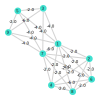

In [6]:
# Graph Checker
graph = get_HN_graph(parameters["images"],-1.0)

elabels = [weights(graph)[e.src, e.dst] for e in edges(graph)]

# Plot with edge labels
gplot(graph, 
      nodelabel=1:nv(graph), 
      edgelabel=round.(elabels, digits=2),)

In [3]:
#Simply changed code to flip if

function HN_og(params)
    scaling = params["scaling"] #Scaling coeff
    S = params["images"] # Images
    time_total= params["sim_time"] # how long the sim is
    num_steps = params["steps"] # number of steps in the sim
    dt_sim = params["delta"] # dt
    delta_t = time_total/num_steps

    # Make Graph
    graph_set = get_HN_graph(S, scaling)
    
    # Making model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)
    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0


    pinned::Vector{Tuple{Int64, Int8}} = []
    spins = Dice.get_random_configuration(num_vertices)
    #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    for stim in parameters["initial_stimuli"]
        # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
        # Adding 1 will bring you to the first entry in the column and so on for +k
        pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
        spins[pos] = stim[3]
        push!(pinned, (pos, stim[3]))
    end

    for i in 1:1000
        res = local_search_pinned_min(model.graph, spins, pinned)
        spins = res
    end
    return spins
end

HN_og (generic function with 1 method)

In [47]:
function minority_flip!(graph::SimpleWeightedGraph, conf::SpinConf, node)
    # Flips conf[node] to be of the opposite sign to the majority of its neighbors

    flip_flag = false
    tot = 0
    for j in neighbors(graph, node)
        tot += conf[node] * conf[j] * weights(graph)[node, j]
    end
    if tot < 0
        conf[node] *= -1
        flip_flag = true
    end
    return flip_flag
end

minority_flip! (generic function with 1 method)

In [48]:
const ModelGraph = Union{SimpleGraph,SimpleWeightedGraph}
function local_search_pinned_min(graph::ModelGraph,
                             conf::SpinConf,
                             list_pinned ::Vector{Int}) ::SpinConf
    nonstop = true
    while nonstop
        nonstop = false
        for node in vertices(graph)
            node in list_pinned && continue
            nonstop |= minority_flip!(graph, conf, node)
        end
    end
    return conf
end

local_search_pinned_min (generic function with 2 methods)

In [7]:
function local_search_pinned_min(graph::ModelGraph,
                             conf::SpinConf,
                             pinned::Vector{Tuple{Int64,Int8}}) ::SpinConf
    pin_indices ::Vector{Int} = []
    for pin in pinned
        conf[pin[1]] = pin[2]
        push!(pin_indices, pin[1])
    end
    return local_search_pinned_min(graph, conf, pin_indices)
end

local_search_pinned_min (generic function with 2 methods)

In [8]:
function HN_og_V2(params)
    scaling = params["scaling"] #Scaling coeff
    S = params["images"] # Images
    time_total= params["sim_time"] # how long the sim is
    num_steps = params["steps"] # number of steps in the sim
    dt_sim = params["delta"] # dt
    delta_t = -1*time_total/num_steps

    # Make Graph
    graph_set = get_HN_graph(S, -1*scaling)
    
    # Making model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)
    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0


    pinned::Vector{Tuple{Int64, Int8}} = []
    spins = Dice.get_random_configuration(num_vertices)
    #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    for stim in parameters["initial_stimuli"]
        # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
        # Adding 1 will bring you to the first entry in the column and so on for +k
        pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
        spins[pos] = stim[3]
        push!(pinned, (pos, stim[3]))
    end

    for i in 1:1000
        res = Dice.local_search_pinned(model.graph, spins, pinned)
        spins = res
    end
    return spins
end

HN_og_V2 (generic function with 1 method)

In [69]:
r = HN_og_V2(parameters)
pretty_table(reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)))

┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │      1 │     -1 │
│     -1 │     -1 │     -1 │
│     -1 │      1 │     -1 │
└────────┴────────┴────────┘


In [121]:
r = HN_og_V2(parameters)

pretty_table(reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)))
conv = 0
for i in 1:1000
    r = HN_og_V2(parameters)
    if (reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
        -1 .*reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
        conv +=1 
    end
end
println(conv)

┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │     -1 │      1 │
│      1 │     -1 │     -1 │
│     -1 │      1 │      1 │
└────────┴────────┴────────┘
1000


In [122]:
r = HN_og_V2(parameters)

pretty_table(reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)))
conv = 0
elp = @elapsed begin
    for i in 1:1000
        r = HN_og_V2(parameters)
        if (reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
            -1 .*reshape(r,size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
            conv +=1 
        end
    end
end
println(conv)
println("took $elp seconds")

┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │     -1 │      1 │
│     -1 │      1 │      1 │
│     -1 │     -1 │      1 │
└────────┴────────┴────────┘
1000
took 0.439087459 seconds


In [123]:
r = HN_Solver(parameters)

pretty_table(reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))

conv = 0
elp = @elapsed begin
    for i in 1:1000
        r = HN_Solver(parameters)
        if (reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
            -1 .*reshape(r[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
            conv +=1 
        end
    end
end
println(conv)
println("took $elp seconds")

┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │     -1 │      1 │
│      1 │      1 │      1 │
│     -1 │     -1 │     -1 │
└────────┴────────┴────────┘
1000
took 1.007938833 seconds


In [124]:
r = HN_Solver_Traj(parameters)

pretty_table(reshape(r[1][1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
save_trajectories(r[2], "3by3","len6")

┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │      1 │     -1 │
│     -1 │      1 │     -1 │
│      1 │     -1 │      1 │
└────────┴────────┴────────┘
File 3by3_1_len6.dat is generated


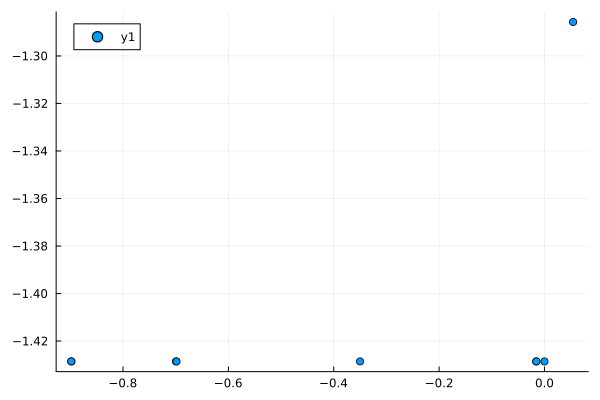

In [125]:
HN_cut_plotter(parameters, r[1])

In [60]:

rots = iterative_rotater_state(r[1], parameters);
for st in rots
    if (reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
        -1 .*reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])

        println("FOUND")
        pretty_table(reshape(st[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    end
end

FOUND
┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│     -1 │      1 │     -1 │
│      1 │     -1 │      1 │
│     -1 │      1 │     -1 │
└────────┴────────┴────────┘
FOUND
┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │     -1 │      1 │
│      1 │      1 │      1 │
│      1 │     -1 │      1 │
└────────┴────────┴────────┘
FOUND
┌────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │
├────────┼────────┼────────┤
│      1 │      1 │      1 │
│      1 │      1 │      1 │
│      1 │      1 │      1 │
└────────┴────────┴────────┘
